In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_year.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_w_genres.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data_by_artist.csv
/kaggle/input/spotify-dataset-19212020-160k-tracks/data.csv


# The Data

We are going to work with Spotify data that includes 19 features to 170653 different tracks that where realesed between 1921 and 2020. There are no missing values.

In [2]:
file_path = '../input/spotify-dataset-19212020-160k-tracks/data.csv'
data = pd.read_csv(file_path)
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [3]:
data.isnull().sum()


valence             0
year                0
acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
id                  0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
dtype: int64

Something that caught my attention when looking at the data was the feature showing the popularity of each song:

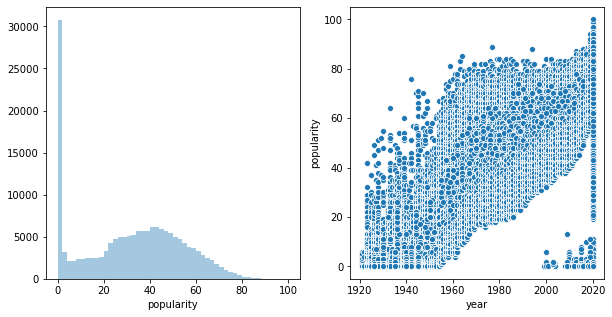

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(a=data.popularity, kde=False)
plt.subplot(1,2,2)
sns.scatterplot(x=data.year, y=data.popularity)

There are a lot of values with 0. It might be missing data...? It might be that older songs are less popular than new hits...?

There is a clear correlation between time and popularity. Since the creator of data states that the popularity rating is a feature provided by Spotify, I assume that the many low ratings are correct data (not missing). We also see that inbetween 1960 and 2019 there are (almost) no non-popular songs. In 2020 it seems like the spectrum of popularity is largest. That might be an effect of an incomplete data set or simply dependent on how this popularity ranking is calculated by Spotify.

The most popular songs within that data are the wollowing according to Spotify:

In [5]:
data.sort_values(by=['popularity'],ascending=False).head(10)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
19611,0.1450,2020,0.40100,"['Bad Bunny', 'Jhay Cortez']",0.731,205090,0.573,1,47EiUVwUp4C9fGccaPuUCS,0.000052,4,0.1130,-10.059,0,Dakiti,100,2020-10-30,0.0544,109.928
19606,0.7560,2020,0.22100,"['24kGoldn', 'iann dior']",0.700,140526,0.722,1,3tjFYV6RSFtuktYl3ZtYcq,0.000000,7,0.2720,-3.558,0,Mood (feat. iann dior),99,2020-07-24,0.0369,90.989
19618,0.7370,2020,0.01120,['BTS'],0.746,199054,0.765,0,0t1kP63rueHleOhQkYSXFY,0.000000,6,0.0936,-4.410,0,Dynamite,97,2020-08-28,0.0993,114.044
19608,0.3570,2020,0.01940,"['Cardi B', 'Megan Thee Stallion']",0.935,187541,0.454,1,4Oun2ylbjFKMPTiaSbbCih,0.000000,1,0.0824,-7.509,1,WAP (feat. Megan Thee Stallion),96,2020-08-07,0.3750,133.073
19610,0.6820,2020,0.46800,['Ariana Grande'],0.737,172325,0.802,1,35mvY5S1H3J2QZyna3TFe0,0.000000,0,0.0931,-4.771,1,positions,96,2020-10-30,0.0878,144.015
19612,0.5430,2020,0.65000,['Pop Smoke'],0.709,160000,0.548,1,1tkg4EHVoqnhR6iFEXb60y,0.000002,10,0.1330,-8.493,1,What You Know Bout Love,96,2020-07-03,0.3530,83.995
19616,0.3340,2020,0.00146,['The Weeknd'],0.514,200040,0.730,0,0VjIjW4GlUZAMYd2vXMi3b,0.000095,1,0.0897,-5.934,1,Blinding Lights,96,2020-03-20,0.0598,171.005
19607,0.3470,2020,0.11400,"['Pop Smoke', 'Lil Baby', 'DaBaby']",0.823,190476,0.586,1,0PvFJmanyNQMseIFrU708S,0.000000,6,0.1930,-6.606,0,For The Night (feat. Lil Baby & DaBaby),95,2020-07-03,0.2000,125.971
19615,0.3720,2020,0.19600,"['Justin Bieber', 'Chance the Rapper']",0.673,212093,0.704,0,5u1n1kITHCxxp8twBcZxWy,0.000000,6,0.0898,-8.056,1,Holy (feat. Chance The Rapper),95,2020-09-18,0.3600,86.919
19620,0.0927,2020,0.86400,"['Justin Bieber', 'benny blanco']",0.631,149297,0.239,1,4y4spB9m0Q6026KfkAvy9Q,0.000000,11,0.1160,-7.071,0,Lonely (with benny blanco),95,2020-10-16,0.0398,79.859


# Prediciton of Danceability

Next we fokus on the danceability. Let's have a look at the histogram and detect some correlated figures with scatterplots.

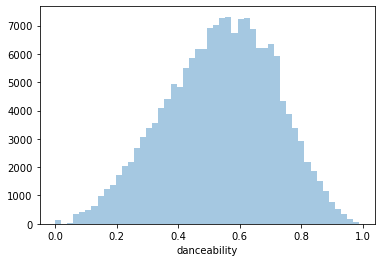

In [6]:
sns.distplot(a=data.danceability, kde=False)

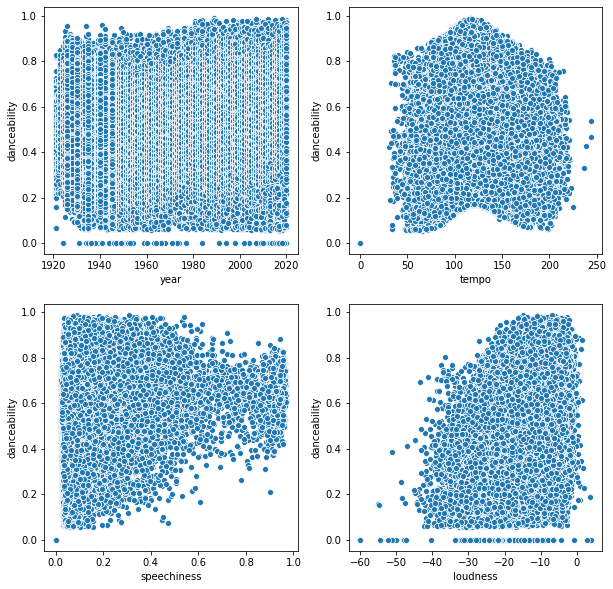

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.scatterplot(x=data.year, y=data.danceability)
plt.subplot(222)
sns.scatterplot(x=data.tempo, y=data.danceability)
plt.subplot(223)
sns.scatterplot(x=data.speechiness, y=data.danceability)
plt.subplot(224)
sns.scatterplot(x=data.loudness, y=data.danceability)

The danceability is quite independent of the year feature. Danceable music is present at all times :D
There seems to be an optimal tempo around 125 BPM for danceability. However, there is more than tempo that influences the danceability. Speachines and loundess could be features that will improve our model.

In the next code cell we have a look at the most danceable hits. Do you know them? Do you notice a flaw in the data?

In [8]:
data.sort_values(by=['danceability'],ascending=False).head(10)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
13489,0.929,1989,0.07550,['Tone-Loc'],0.988,248160,0.633,0,5YIF6HSOtHN9HdcE5IPzMe,0.000002,5,0.0668,-15.012,0,Funky Cold Medina,56,1989-01-01,0.0888,117.493
167931,0.761,2007,0.14500,"['Young Boss', 'Trina', 'Pitbull']",0.986,229669,0.597,1,5IbMUI4rcWtXlq83UWqTcQ,0.000002,8,0.1970,-6.809,1,Go Girl,43,2007-11-27,0.3080,115.004
73561,0.761,2012,0.14500,"['Pitbull', 'Trina', 'Young Bo']",0.986,229669,0.597,1,1MgM0WDaoQ2A3bnIQTR6ty,0.000002,8,0.1970,-6.809,1,Go Girl,54,2012-05-08,0.3080,115.004
170107,0.584,2018,0.21200,['ITSOKTOCRY'],0.985,138715,0.438,1,5N6USyYyAuSyysUQ1xncYc,0.000054,1,0.1160,-11.004,1,"POP, LOCK & DROPDEAD",60,2018-03-18,0.0712,118.079
154089,0.105,2015,0.00366,['Astra Teck'],0.983,419999,0.673,0,2uFhbAbYjgvjnNkZ2tuMUA,0.687000,7,0.1120,-6.013,1,Monday Nineteen Hours,0,2015-10-30,0.1830,127.991
151032,0.823,1997,0.03000,['Daft Punk'],0.980,173493,0.486,0,4ZdjCuiWBv2weLftWPJ72c,0.823000,6,0.0995,-7.310,1,Teachers,42,1997-01-16,0.2510,123.206
57388,0.764,2020,0.67100,['347aidan'],0.980,180139,0.413,0,6Pgmqg15yVexuOgtzuxwoX,0.000080,8,0.1700,-11.052,0,Dancing in My Room,77,2020-10-26,0.1010,119.993
50158,0.891,1984,0.28300,"['The Jacksons', 'Mick Jagger']",0.980,271000,0.846,0,1sLTxLJzyoBJiPzv420KAx,0.149000,8,0.0520,-7.696,0,State of Shock,43,1984-10-30,0.1390,121.562
13655,0.675,1990,0.02700,['Vanilla Ice'],0.980,271467,0.535,0,11d9oUiwHuYt216EFA2tiz,0.000002,2,0.1040,-16.035,1,Ice Ice Baby,61,1990-01-01,0.0580,115.744
37924,0.411,2017,0.08290,['XXXTENTACION'],0.979,151249,0.401,1,5UJ3N25ukIruG4Do8RDHra,0.011000,7,0.0657,-7.401,1,UP LIKE AN INSOMNIAC - Freestyle,69,2017-12-19,0.4070,120.002


The songs 'GO Girl' is listed twice, differing only in the id, the order of the artists and the way the artist Young Boss (or Young Bo) was written.

In [9]:
#drop several features:
df = data.drop(['artists','id','name','release_date','popularity'],axis=1)
df.shape

(170653, 14)

* I droped **popularity** (int in 1-100) due to that we migth want to make an dancability prediction before releasing a song.
* Also the **artists** were dropped since I expect them to be quite irrelevant for the dancability measure.
* The **release_date** is a column containing dates of differing format. I kept the column year and droped the to some extent redundant information in release_date.
* The **id** and the **name** column contain a (in the majority of cases) unique identifier for each song which is irrelevant for our model.

In [10]:
#split data in train, validation and test set like 60:20:20
train, valid, test = np.split(df.sample(frac=1, random_state=42),[int(.6*len(data)), int(.8*len(data))])

#rescaling of data
max_ = train.max(axis=0)
min_ = train.min(axis=0)
delta_ = max_ - min_
train = (train - min_) / delta_
valid = (valid - min_) / delta_
test = (test - min_) / delta_

#prepare data for DL
y_train = train.danceability
X_train = train.drop(['danceability'], axis=1)
y_valid = train.danceability
X_valid = train.drop(['danceability'], axis=1)
y_test = train.danceability
X_test = train.drop(['danceability'], axis=1)

In [11]:
X_train.shape

(102391, 13)

# Deep Learning Approach
First, I tried a deep learning model for predicting the danceability of the song.

Minimum validation loss: 0.09126854687929153


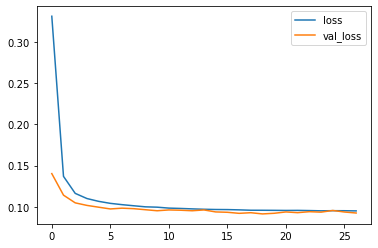

In [12]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

dl_model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(20, activation='relu', input_shape=[df.shape[1]]),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(20, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1),
])

dl_model.compile(
    optimizer="adam",
    loss="mae",
)

history = dl_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=265,
    epochs=100,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

Both loss and validation learning curves drop rapidely after the first epoch and continue to gradually decrease further. Neither over- nor underfitting seem to be an issue. Remember that the danceability value lies in the interval [0,1], so we reach an prediciton error of 7,8 percent in mean. Maybe we can go even lower using a random forest.

In [13]:
#check with test data
y_predict = dl_model.predict(X_test)
print('The MAE for the test data set is: ', mean_absolute_error(y_test, y_predict))

The MAE for the test data set is:  0.0919736714811763


# Random Forest Approach
I tried a random forest model to predict the danceability of the song.

In [14]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train, y_train)
y_forest_predict = forest_model.predict(X_valid)
print('The MAE for the validation data set is: ', mean_absolute_error(y_valid, y_forest_predict))

The MAE for the validation data set is:  0.028898174364177874


This seems to be quite a good predictor for the danceability value between [0,1]. On average the prediction differed with arround 2.8 percent from the by Spotify assigned danceability.

In [15]:
#check with test data
y_predict = forest_model.predict(X_test)
print('The MAE for the test data set is: ', mean_absolute_error(y_test, y_predict))

The MAE for the test data set is:  0.028898174364177874
